In [79]:
import os
import re
import io
import requests
from dotenv import load_dotenv
from tavily import TavilyClient
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_groq import ChatGroq

from PyPDF2 import PdfReader

In [80]:
load_dotenv()

True

In [ ]:
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [82]:
tavily_client = TavilyClient(TAVILY_API_KEY)

In [83]:
def extract_content(url: str) -> str:
    """
    Extracts content from a given URL using the Tavily API.
    Args:
        url (str): The URL from which to extract content.
    Returns:
        str: The extracted content in markdown format.
    """
    response = tavily_client.extract(url, format="markdown")
    result = response.get("results")
    return result[0].get("raw_content", "")

In [84]:
def get_transcript_url() -> str:
    """
    Extracts the first transcript URL from the Power Finance Corporation's concalls page.
    Returns:
        str: The first transcript URL found in the concalls section.
    """
    marker = "### Concalls"

    try:
        concalls_data = extract_content("https://www.screener.in/company/PFC/consolidated/").split(marker)[1]

        end_markers = ["Notes", "[PPT]", "PPT"]
        for em in end_markers:
            if em in concalls_data:
                concalls_data = concalls_data.split(em)[0]
                break

        url_pattern = r'\[Transcript\]\((.*?)\)'
        urls = re.findall(url_pattern, concalls_data)
        
        if urls:
            first_url = urls[0].strip()
            first_url = first_url.split()[0] if first_url else ""
            return first_url
        else:
            return f"No transcript URLs found."

    except IndexError:
        return f"The marker '{marker}' was not found in the text."

In [85]:
def get_transcript_summary(text: str) -> str:
    """
    Splits the given text into two parts and analyzes each part using a language model.
    Args:
        text (str): The text to be analyzed, typically a concall transcript.
    Returns:
        None: Prints the analysis of each part and a combined summary.
    """

    text_length = len(text)
    mid_point = text_length // 2
    
    break_point = mid_point
    for i in range(mid_point, min(mid_point + 1000, text_length)):
        if text[i] in '.!\n':
          break_point = i + 1
          break
    
    text_part1 = text[:break_point]
    text_part2 = text[break_point:]
    
    groq_llm = ChatGroq(
        model="llama-3.1-8b-instant",
        temperature=0,
        max_retries=2,
    )

    messages_part1 = [
        SystemMessage(content=(
      "You are a financial analyst who knows how to analyze financial data and provide insights based on it. "
      "You have expertise in analyzing the concall transcripts of companies. "
      "You will be given the FIRST PART of a transcript of a concall in markdown format, and you will analyze it "
      "and provide insights. Focus on the positives and negatives of the company based on this part of the transcript. "
      "You will be completely honest and transparent in your analysis, and you will not make any assumptions or guesses. "
      "You will also analyse the management's tone and sentiment in this part of the transcript. "
      "Note: This is PART 1 of 2 - provide analysis but mention that this is partial analysis."
        )),
        HumanMessage(content="Analyze concall transcript and give detailed summary:\n\n" + text_part1)
    ]

    llm_response_part1 = groq_llm.invoke(messages_part1)
    # print(llm_response_part1.content)

    messages_part2 = [
        SystemMessage(content=(
      "You are a financial analyst who knows how to analyze financial data and provide insights based on it. "
      "You have expertise in analyzing the concall transcripts of companies. "
      "You will be given the SECOND PART of a transcript of a concall in markdown format, and you will analyze it "
      "and provide insights. Focus on the positives and negatives of the company based on this part of the transcript. "
      "You will be completely honest and transparent in your analysis, and you will not make any assumptions or guesses. "
      "You will also analyse the management's tone and sentiment in this part of the transcript. "
      "Note: This is PART 2 of 2 - provide final comprehensive analysis and overall summary combining insights from both parts."
        )),
        HumanMessage(content="Analyze the concall transcript and give detailed summary with overall conclusion:\n\n" + text_part2)
    ]

    llm_response_part2 = groq_llm.invoke(messages_part2)

    combine_llm_response = groq_llm.invoke([
        SystemMessage(content=(
            "You are a financial analyst who knows how to analyze financial data and provide insights based on it. "
            "You will be given the analysis from PART 1 and PART 2 of a concall transcript, and you will combine them "
            "to provide a final comprehensive analysis and overall summary."
            "there should be combined sections such as overview, positives, negatives, management tone and sentiment, and conclusion."
            "You will have to provide the detailed summary with explanattions of terms used in the analysis."
        )),
        HumanMessage(content="Combine the insights from both parts:\n\n" + llm_response_part1.content + "\n\n" + llm_response_part2.content)
    ])
    # print(combine_llm_response.content)
    return combine_llm_response.content

In [86]:
def download_transcript(url: str) -> str:
    """
    Downloads a PDF from the given URL and extracts its text content.
    Args:
        url (str): The URL of the PDF file to download.
    Returns:
        str: The extracted text content from the PDF.
    """
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    response = requests.get(url, headers=headers, timeout=30)
    file_stream = io.BytesIO(response.content)
    
    try:
        reader = PdfReader(file_stream)
        print(f"PDF successfully loaded. Number of pages: {len(reader.pages)}")
        
        text = ""
        for i, page in enumerate(reader.pages):
            try:
                page_text = page.extract_text()
                text += page_text
                
            except Exception as e:
                print(f"Error extracting text from page {i+1}: {e}")
                continue
        
        print(f"Successfully extracted {len(text)} characters of text")
        text = ''.join(char for char in text if ord(char) < 128)

        return text
        
    except Exception as e:
        print(f"Error reading PDF: {e}")
        return "Error: Could not read the PDF file"

In [87]:
def get_news_urls_data(): 
  """
  Fetches news articles related to Power Finance Corporation from Reuters using the Tavily API.
  Returns:
    str: The extracted data from each news article as a single string.
  """ 

  urls = []
  try:
    news_reuters = tavily_client.search("site:reuters.com Power Finance corporation get news", days=30)
    for result in news_reuters.get("results", []):
      if "url" in result:
        urls.append(result["url"])
  except Exception as e:
    print(f"Error searching for news: {e}")
    return "Error: Could not fetch news URLs"

  extracted_data = []
  for url in urls:
    try:
      url_data = tavily_client.extract(url, format="markdown")
      results = url_data.get("results", [])
      if results and len(results) > 0:
        raw_content = results[0].get("raw_content", "")
        if raw_content:
          extracted_data.append(raw_content)
    except Exception as e:
      print(f"Error extracting data from {url}: {e}")
      continue

  if not extracted_data:
    return "No news data could be extracted"
  
  news_data = '\n'.join(str(item) for item in extracted_data)
  return news_data

In [88]:
def get_llm_response(raw_content: str , transcript_summary: str, news_data: str) -> str:
    """
    Analyzes financial data using a language model and provides insights.
    Returns:
        None: Prints the insights generated by the language model.
    """
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )

    if isinstance(raw_content, list):
        raw_content = '\n'.join(str(item) for item in raw_content)
    if isinstance(transcript_summary, list):
        transcript_summary = '\n'.join(str(item) for item in transcript_summary)
    if isinstance(news_data, list):
        news_data = '\n'.join(str(item) for item in news_data)


    messages = [
        SystemMessage(content=(
            "You are a financial analyst who knows how to analyze financial data and provide insights based on it. "
            "You will be given financial data in markdown format, and you will analyze it and provide insights. "
            "You will only respond with the insights and nothing else. "
            "You know how to analyze the financial ratios."
            "Add a detailed information about financial ratios, their value and their interpretations, also add a risk o meter that classifies the risk associated with each ratio. Also compare them with what is ideal scenario of that ratio. YOu have to provide the best possible insights based on the data provided."
            "You will analyze the concall transcript and provide detailed insights based on it."
            "You will also analyze the news data related to the company and try to assess its impact on the performance of the stock."
            "For the conclusion, you will provide a summary of the financial health of the company based on the data provided in detail."
            "You will be completely honest and transparent in your analysis, and you will not make any assumptions or guesses."
            "Focus on the details given to you and note that you are extraordinarily good at analyzing financial data and providing insights based on it."
            "note that you will not construct any markdown table, you will just provide the insights in text."
            ""
        )),
        HumanMessage(content="Analyze the following financial data and provide very detailed and indepth insights:\n\n" + raw_content + "\n\n" + transcript_summary + "\n\n" + news_data)
    ]

    llm_response = llm.invoke(messages)
    print(llm_response.content)

In [89]:
# raw_content = extract_content("https://www.screener.in/company/PFC/consolidated/")
# transcript_url = get_transcript_url()
# transcript = download_transcript(transcript_url)
# transcript_summary = get_transcript_summary(transcript)
# news_data = get_news_urls_data()
# ans = get_llm_response(raw_content, transcript_summary, news_data)

In [90]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda, RunnableConfig
from typing import Dict, TypedDict, Optional
from enum import Enum

class AnalysisTool(str, Enum):
    FINANCIALS = "financials"
    NEWS = "news"
    TRANSCRIPT = "transcript"
    FULL = "full"

class AnalysisState(TypedDict):
    user_query: str
    tool: Optional[AnalysisTool]
    raw_content: Optional[str]
    transcript_url: Optional[str]
    transcript: Optional[str]
    transcript_summary: Optional[str]
    news_data: Optional[str]
    final_output: Optional[str]

In [91]:
workflow = StateGraph(AnalysisState)
response_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0, max_tokens=None, timeout=None, max_retries=2)

def route_query(state: AnalysisState) -> Dict[str, AnalysisTool]:
    """Determine which analysis tool to use based on user query"""
    query = state["user_query"].lower()
    
    if "news" in query and "transcript" not in query and "financial" not in query:
        return {"tool": AnalysisTool.NEWS}
    elif "transcript" in query and "news" not in query and "financial" not in query:
        return {"tool": AnalysisTool.TRANSCRIPT}
    elif "financial" in query and "news" not in query and "transcript" not in query:
        return {"tool": AnalysisTool.FINANCIALS}
    elif "full" in query or "complete" in query or "all" in query:
        return {"tool": AnalysisTool.FULL}
    else:
        return {"tool": AnalysisTool.FULL}

workflow.add_node("router", RunnableLambda(route_query))

def fetch_financials(state: AnalysisState) -> Dict[str, str]:
    if state["tool"] not in [AnalysisTool.FINANCIALS, AnalysisTool.FULL]:
        return {}
    return {"raw_content": extract_content("https://www.screener.in/company/PFC/consolidated/")}

def fetch_news(state: AnalysisState) -> Dict[str, str]:
    if state["tool"] not in [AnalysisTool.NEWS, AnalysisTool.FULL]:
        return {}
    return {"news_data": get_news_urls_data()}

def process_transcript(state: AnalysisState) -> Dict[str, str]:
    if state["tool"] not in [AnalysisTool.TRANSCRIPT, AnalysisTool.FULL]:
        return {}
    
    transcript_url = get_transcript_url()
    transcript = get_transcript(transcript_url)
    transcript_summary = get_transcript_summary(transcript)
    
    return {
        "transcript_url": transcript_url,
        "transcript": transcript,
        "transcript_summary": transcript_summary
    }

def run_full_analysis(state: AnalysisState) -> Dict[str, str]:
    if state["tool"] != AnalysisTool.FULL:
        return {}
    
    if not all([state.get("raw_content"), state.get("transcript_summary"), state.get("news_data")]):
        return {"final_output": "Error: Missing data for full analysis"}
    
    return {"final_output": get_llm_response(
        state["raw_content"],
        state["transcript_summary"],
        state["news_data"]
    )}

workflow.add_node("get_financials", RunnableLambda(fetch_financials))
workflow.add_node("get_news", RunnableLambda(fetch_news))
workflow.add_node("get_transcript", RunnableLambda(process_transcript))
workflow.add_node("full_analysis", RunnableLambda(run_full_analysis))

RESPONSE_TEMPLATES = {
    "news": """
    You are a financial news analyst. Summarize and analyze the following news articles about {company}.
    Focus on:
    - Key developments
    - Potential market impact
    - Sentiment analysis
    - Any notable events or announcements
    
    News Articles:
    {content}

    Provide a well-structured 3-4 paragraph analysis and the potential impact of the news on stock.
    """,
    
    "transcript": """
    You are a concall transcript analyst. Analyze this earnings call transcript for {company}:
    
    {content}
    
    Provide:
    1. Key takeaways (3-5 bullet points)
    2. Management tone and sentiment analysis
    3. Notable questions from analysts
    4. Any surprises or deviations from expectations
    5. Overall assessment (positive/neutral/negative)
    """,
    
    "financials": """
    Analyze these financial metrics for {company}:
    
    {content}
    
    Provide:
    1. Key financial ratios and their interpretation
    2. Strengths and weaknesses
    3. Comparison to industry benchmarks if available
    4. Trend analysis (improving/declining metrics)
    5. Overall financial health assessment
    """,
    
    "full": """
    Conduct a comprehensive analysis of {company} based on:
    - Financial data
    - Earnings call transcript
    - Recent news
    
    Financial Data:
    {financials}
    
    Transcript Summary:
    {transcript}
    
    News Summary:
    {news}
    
    Provide a detailed 5-7 paragraph investment analysis covering:
    1. Financial health
    2. Management commentary insights
    3. Recent developments
    4. Risk factors
    5. Overall investment recommendation (Buy/Hold/Sell) with rationale
    """
}

def generate_ai_response(content: str, analysis_type: str, company: str = "PFC") -> str:
    """Generate a polished AI response based on the analysis type"""
    template = RESPONSE_TEMPLATES.get(analysis_type, RESPONSE_TEMPLATES["full"])
    
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | response_llm
    
    if analysis_type == "full":
        response = chain.invoke({
            "company": company,
            "financials": content.get("raw_content", ""),
            "transcript": content.get("transcript_summary", ""),
            "news": content.get("news_data", "")
        })
    else:
        response = chain.invoke({
            "company": company,
            "content": content
        })
    
    return response.content

def format_output(state: AnalysisState) -> Dict[str, str]:
    """Format the final output using AI"""
    tool = state.get("tool")
    company = "Power Finance Corporation"
    
    try:
        if tool == AnalysisTool.NEWS:
            content = state.get("news_data", "")
            analysis = generate_ai_response(content, "news", company)
            
        elif tool == AnalysisTool.TRANSCRIPT:
            content = state.get("transcript_summary", "")
            analysis = generate_ai_response(content, "transcript", company)
            
        elif tool == AnalysisTool.FINANCIALS:
            content = state.get("raw_content", "")
            analysis = generate_ai_response(content, "financials", company)
            
        elif tool == AnalysisTool.FULL:
            analysis = generate_ai_response(state, "full", company)
            
        else:
            analysis = "No analysis available for your query"
            
        return {"final_output": analysis}
        
    except Exception as e:
        return {"final_output": f"Error generating analysis: {str(e)}"}

workflow.add_node("format_output", RunnableLambda(format_output))

workflow.set_entry_point("router")

def decide_edges(state: AnalysisState) -> str:
    tool = state.get("tool")
    if tool == AnalysisTool.FINANCIALS:
        return "get_financials"
    elif tool == AnalysisTool.NEWS:
        return "get_news"
    elif tool == AnalysisTool.TRANSCRIPT:
        return "get_transcript"
    elif tool == AnalysisTool.FULL:
        return "get_financials"
    else:
        return "format_output"

In [92]:
workflow.add_conditional_edges(
    "router",
    decide_edges,
    {
        "get_financials": "get_financials",
        "get_news": "get_news",
        "get_transcript": "get_transcript",
        "format_output": "format_output"
    }
)

workflow.add_edge("get_financials", "format_output")
workflow.add_edge("get_news", "format_output")
workflow.add_edge("get_transcript", "format_output")

workflow.add_edge("get_financials", "get_transcript")
workflow.add_edge("get_transcript", "get_news")
workflow.add_edge("get_news", "full_analysis")
workflow.add_edge("full_analysis", "format_output")

workflow.add_edge("format_output", END)

analyst_workflow = workflow.compile()

In [96]:
def analyze_query(query: str) -> str:
    try:
        result = analyst_workflow.invoke(
            {"user_query": query},
            RunnableConfig(recursion_limit=100)
        )
        return result.get("final_output", "No analysis results available")
    except Exception as e:
        return f"Error processing your query: {str(e)}"

if __name__ == "__main__":
    queries = [
        "get me the latest news about Power Finance Corporation",
    ]
    
    for query in queries:
        print(f"\nQuery: {query}")
        print("-" * 50)
        print(analyze_query(query))
        print("=" * 80)


Query: get me the latest news about Power Finance Corporation
--------------------------------------------------
Here's a summary and analysis of the provided news articles about Power Finance Corporation (PFC), focusing on key developments, potential market impact, sentiment, and notable events:

**Summary of Key Developments:**

The news articles present a mixed picture for PFC. On the positive side, PFC received government approval to issue up to 100 billion rupees in deep-discount, long-tenor (10 years and 1 month) zero-coupon bonds. This provides PFC with a new avenue for raising funds and diversifies its borrowing instruments. The company is also planning to raise 80 billion rupees through bonds with shorter maturities. Furthermore, PFC has approved a substantial borrowing program of 1.4 trillion rupees for the upcoming financial year. The financial data shows a strong growth in revenue and net income for PFC in 2025 compared to previous years.

However, there are significant ne

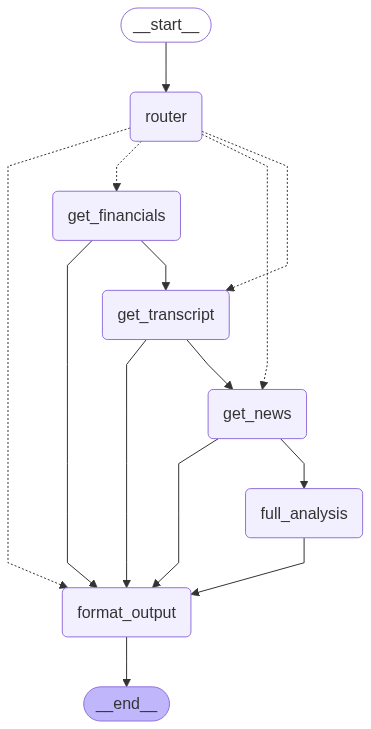

In [94]:
from IPython.display import Image, display

display(Image(analyst_workflow.get_graph().draw_mermaid_png()))

In [95]:
ans = tavily_client.extract("https://cdn-media.screener.in/concalls/3dc79c8f-9b65-4269-84e2-00a044b04c6a.pdf", extract_depth="advanced", format="markdown")
print(ans)

{'results': [{'url': 'https://cdn-media.screener.in/concalls/3dc79c8f-9b65-4269-84e2-00a044b04c6a.pdf', 'raw_content': '1ational Stock Exchange of India Ltd, I isting Department. l¥xchange PlaJ\'.a, Bandra Kurla Complex. 13andra (E) Ml\'MBAI -400 051. Q<fB0.\\Jj Jflq?"! Rif!lc\\s " fui.m, QcfB0\'\\Jj #. \x03-Wffi q51J.t.8cfB, $ (TD, %-400 ost qlq\'< 4>1\x1e;jff ct>1cif\x1f}IF1 \x03file\x04 POWER FINANCE CORPORATION LTD. (1-Tffil \x1b cpl ) (;irr{"°\'1;in 450012010 wn0m) BSE Limited, (A Govt. of India Undertaking) (ISO 45001:2018 Certified) No: I : 05: 138: I: CS Dated: 28.05.2025 Department of Corporate Services, Floor- 25, P.1 Towers, Dalal Street, MUMBAI -400 001.\n¦ RIFR§6, cITTGfu\x1bt&iw-r, -25, lft. s- t. u v. w-400 00 l Sl B: Transcript of analyst/investor meet held on May 21, 2025 Madam/Sir. In continuation of our earlier letter dated May 14, 2025, May 19, 2025 and May 21, 2025 and pursuant to Regulation 30 read with Schedule III of the SEBI (Listing Obligations and Disclosure 